Initializations 

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt, log
# import print_options
np.set_printoptions(precision=3)

Create a class to define the karmed-bandit problem. 

In [17]:
class Bandit(object):
    """
    Class that defines the k-armed Bandit. Rewards of the arms are assumed
    to be drawn from a normal distribution with standard deviation = 1
        Parameters:
            kArms: Number of arms of k-armed bandit
            mu: means of the reward distributions associated with the k-arms

    """
    def __init__(self, kArms, mu, sd, nsflag):
        self.kArms = kArms
        self.mu = mu
        self.sd = sd
        self.actionArr = np.zeros(kArms)
        self.nonStatFlag = nsflag

    def get_reward(self, k):
        """

        :param k: k-th arm
        :return: reward
        """
        return np.random.normal(self.mu[k], 1)
    
    
    def update_mu(self):
        t = np.random.normal(0, 0.001, self.kArms)  # update to means
        self.mu = self.mu + t

    def plot(self, r,c,x):
        """
        Plots of the mean and std of the k-distributions
        """
        plt.subplot(r,c,x)
        plt.plot(np.arange(self.kArms) + 1, self.mu, 'ro', label='Bandit')
        plt.errorbar(np.arange(self.kArms)+1, self.mu, yerr=np.ones(self.kArms), fmt='none', label='SD')
        plt.grid()
        plt.legend()
        # plt.show()

Now a class to define the agent and how it updates it's choices based on rewards 

In [110]:
class Agent(object):
    """
    Class that defines the agent trying to identify the arm with the best reward
        Parameters:
            iternum: number of iteration that the agent goes through
            eps: probability with which the agent chooses an action at random,
                otherwise makes greedy choices
            nArms: number of arms of the bandit
    """
    def __init__(self, eps, nArms, init_val, ucb = 0, c=1):
        # self.iter = iternum
        self.eps = eps
        self.t = 0
        self.Qarray = init_val * np.ones(shape=(nArms))
        self.Narray = np.zeros(shape=(nArms))
        self.nArms = nArms
        if ucb == 0:
            self.mode = 'random'
        else:
            self.c = c
            self.mode = 'ucb'
            

    def action(self):
        """
        Makes a choice based on mode
        :param mode: random or UCB. If random, the choice is made using the eps-greedy approach. 
        :return: action index a
        """
        if self.mode == 'random':
            choiceProb = np.random.uniform(0, 1, 1)

            if choiceProb <= self.eps:
                a = random.choice(range(self.nArms))
            else:
                maxQ = np.max(self.Qarray)
                possibleActions = [i for i, x in enumerate(self.Qarray) if x == maxQ]
                a = np.random.choice(possibleActions)
        else:
            if self.t == 0:
                a = np.random.choice(range(self.nArms))
            else:
                ActArray = np.zeros(self.nArms) # array to hold UCB value
                for j in range(self.nArms):
                    if self.Narray[j] == 0 or self.t <= 2*self.nArms:
                        ActArray[j] = self.Qarray[j]
                    else:
                        ActArray[j] = self.Qarray[j] + self.c*sqrt(log(self.t)/self.Narray[j])
#                 print(ActArray)
                maxA = np.max(ActArray)
                possibleActions = [i for i, x in enumerate(ActArray) if x == maxA]
                a = np.random.choice(possibleActions) # select value of action
                
            self.t = self.t + 1 # update time 
            self.Narray[a] = self.Narray[a] + 1 #update action array
                        
        return a

    def get_best_action(self):
        # print(self.Qarray)
        return np.argmax(self.Qarray)

Now a class for the Environment 

In [41]:
class Environment(object):
    def __init__(self, test, agent, plays):
        self.bandit = test
        self.agent = agent
        self.plays = plays
        self.Rarray = np.zeros(shape=plays)
        self.play()
        
    def play(self):
        """
        iteratively plays choosing actions at random or taking the greedy
        approach with probability eps

        """
        for i in range(self.plays):
            a = self.agent.action()
            self.update_agent(a, i)
            if self.bandit.nonStatFlag == 1 and i%10 == 0:
                self.bandit.update_mu()


    def update_agent(self, a, index):
        """
        Update agent with feedback from bandit

            :param a: action number
            :param index: index of play
            :return: none
        """
        reward = self.bandit.get_reward(a)
        self.agent.Narray[a] = self.agent.Narray[a] + 1
        self.agent.Qarray[a] = self.agent.Qarray[a] + (1 / self.agent.Narray[a]) * (reward - self.agent.Qarray[a])
        self.Rarray[index] = np.max(self.agent.Qarray)

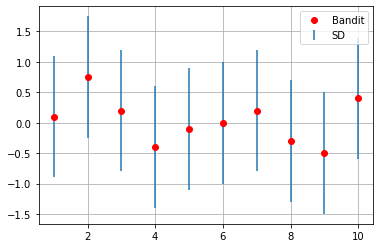

In [42]:
kArms = 10
mu_range = [i for i in np.arange(-1, 1, 0.2)]
mu = np.array(random.sample(mu_range, kArms)) # means of k-distributions
mu = [0.1, 0.75, 0.2, -0.4, -0.1, 0, 0.2, -0.3, -0.5, 0.4]
sd = np.random.uniform(0.5, 1.5, 10)

# set up bandit
bandit = Bandit(kArms=kArms, mu=mu, sd = sd, nsflag = 0)
bandit.plot(1,1,1)# visualize karmed bandit 

In [47]:
# set up greedy, and two eplison agents 
agent1 = Agent(0, kArms, 0, ucb=0) # greedy
agent2 = Agent(0.01, kArms, 0, ucb=0) #eps = 0.01
agent3 = Agent(0.1, kArms, 0, ucb=0) #eps = 0.1
plays = 2500
env1 = Environment(bandit, agent1, plays)
env2 = Environment(bandit, agent2, plays)
env3 = Environment(bandit, agent3, plays)

print("Mu vs estimate (greedy) = ", bandit.mu[agent1.get_best_action()], 
      agent1.Qarray[agent1.get_best_action()])
print("Mu vs estimate (eps = 0.01) = ", bandit.mu[agent2.get_best_action()], 
      agent2.Qarray[agent2.get_best_action()])
print("Mu vs estimate (eps = 0.1) = ", bandit.mu[agent3.get_best_action()], 
      agent3.Qarray[agent3.get_best_action()])

Mu vs estimate (greedy) =  0.75 0.7351337121201276
Mu vs estimate (eps = 0.01) =  0.75 0.7583265343130663
Mu vs estimate (eps = 0.1) =  0.75 0.746896656930675


Create plots to visualize iterative process

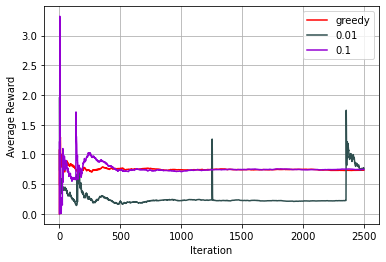

In [48]:
plt.plot(range(plays), env1.Rarray, 'r', label='greedy')
plt.plot(range(plays), env2.Rarray, 'darkslategrey', label='0.01')
plt.plot(range(plays), env3.Rarray, 'darkviolet', label='0.1')
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Iteration')
plt.legend()

Mu vs estimate (optimistic greedy) =  0.75 0.7305124996358598
Mu vs estimate (eps = 0.1) =  0.75 0.7513763191733797


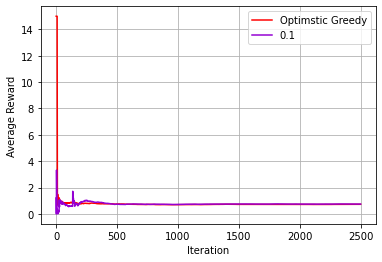

In [49]:
# now explore optimistic initial values 
# set up greedy, and one eplison agents 
agent1 = Agent(0, kArms, 15) # greedy
agent2 = Agent(0.1, kArms, 0) #eps = 0.01

plays = 2500
env1 = Environment(bandit, agent1, plays)
env2 = Environment(bandit, agent2, plays)


print("Mu vs estimate (optimistic greedy) = ", bandit.mu[agent1.get_best_action()], 
      agent1.Qarray[agent1.get_best_action()])
print("Mu vs estimate (eps = 0.1) = ", bandit.mu[agent2.get_best_action()], 
      agent2.Qarray[agent2.get_best_action()])

# plots
plt.plot(range(plays), env1.Rarray, 'r', label='Optimstic Greedy')
plt.plot(range(plays), env3.Rarray, 'darkviolet', label='0.1')
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Iteration')
plt.legend()


Mu vs estimate (optimistic greedy) =  0.19835934548104936 0.20951067763349518
Mu vs estimate (eps = 0.1) =  0.788251721715117 0.7601120857844723


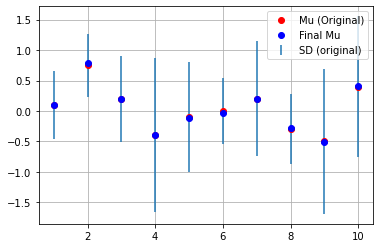

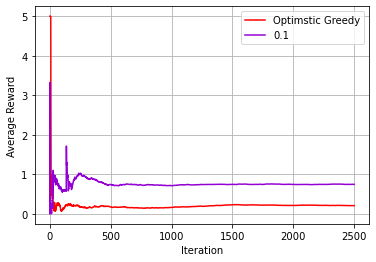

In [67]:
# how about when the bandit is non-stationary? 
bandit = Bandit(kArms=kArms, mu=mu, sd = sd, nsflag = 1)

# set up greedy, and one eplison agents 
agent1 = Agent(0, kArms, 5) # greedy
agent2 = Agent(0.1, kArms, 0) #eps = 0.01

plays = 2500
env1 = Environment(bandit, agent1, plays)
env2 = Environment(bandit, agent2, plays)


print("Mu vs estimate (optimistic greedy) = ", bandit.mu[agent1.get_best_action()], 
      agent1.Qarray[agent1.get_best_action()])
print("Mu vs estimate (eps = 0.1) = ", bandit.mu[agent2.get_best_action()], 
      agent2.Qarray[agent2.get_best_action()])

# plots

plt.plot(np.arange(kArms) + 1, mu, 'ro', label='Mu (Original)')
plt.errorbar(np.arange(kArms)+1, mu, yerr=sd, fmt='none', label='SD (original)')
plt.plot(np.arange(kArms) + 1, bandit.mu, 'bo', label='Final Mu')
# plt.errorbar(np.arange(kArms)+1, mu, yerr=bandit.sd, fmt='none', label='SD (Final)')
plt.grid()
plt.legend()
plt.show()

plt.plot(range(plays), env1.Rarray, 'r', label='Optimstic Greedy')
plt.plot(range(plays), env3.Rarray, 'darkviolet', label='0.1')
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Iteration')
plt.legend()
plt.show()

Let's try the upper confidence bound action selection 

Mu vs estimate (optimistic greedy) =  0.75 0.7402859783531511
Mu vs estimate (eps = 0.1) =  0.75 0.7351360803303266


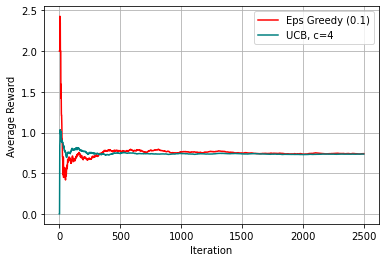

In [118]:
bandit = Bandit(kArms=kArms, mu=mu, sd = sd, nsflag=0)

# set up greedy, and one eplison agents 
agent1 = Agent(0.1, kArms, 2) # greedy
agent2 = Agent(0, kArms, 0, ucb=1, c=4) #eps = 0.1

plays = 2500
env1 = Environment(bandit, agent1, plays)
env2 = Environment(bandit, agent2, plays)


print("Mu vs estimate (optimistic greedy) = ", bandit.mu[agent1.get_best_action()], 
      agent1.Qarray[agent1.get_best_action()])
print("Mu vs estimate (eps = 0.1) = ", bandit.mu[agent2.get_best_action()], 
      agent2.Qarray[agent2.get_best_action()])


plt.plot(range(plays), env1.Rarray, 'r', label='Eps Greedy (' + str(agent1.eps) + ')')
plt.plot(range(plays), env2.Rarray, 'teal', label='UCB, c=' + str(agent2.c))
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Iteration')
plt.legend()
plt.show()